# Gaussian Process Regression

 In this notebook, I present the GP regression workflow for noisy, non-uniform data. To demonstrate the robustness of the method, I will be using the CGILS_S6 run.

In [1]:
# Set up local project directory path
from pathlib import Path
from tqdm.notebook import tqdm
import sys

project_src = Path('../src').resolve().as_posix()
sys.path.insert(0, project_src)

# try:
#     import lib.config
# except Exception:
#     raise Exception("Issue with dynamic import")

# config = lib.config.read_config()
# pwd = Path(config["pwd"])
src = Path('../output')

In [2]:
# Import modules needed for the rest of the notebook
import numpy as np
import pandas as pd

import sklearn.preprocessing as skl_prep
from statsmodels.nonparametric import smoothers_lowess as sl

# Pytorch + GP
import torch, gpytorch

In [3]:
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': True, 
        'axes.linewidth': '1',
        'grid.color': '0.5',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })
xkcd = sns.xkcd_rgb


rc_opt = {
    "figure.dpi": 300,
    "font.family": "serif",
    "font.size": 15,
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{libertine} \usepackage[libertine]{newtxmath}",
}
mpl.rcParams.update(rc_opt)

In [4]:
# CUDA setup
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

if device.type == 'cuda':
    print(f"Using {torch.cuda.get_device_name(0)}")
else:
    print(f"Using {device}")

Using cpu


# CGILS_S6 Slope Timeseries

 Let's load the dataset. We will be using a 12-hour data from a BOMEX run with a swamp ocean. It is rather unstable (due to the shallow ocean getting too hot too quickly), which is why I did a series of model runs to obtain a statically stable case. 

 The following method works perfectly well for CGILS_S6 case, which maintains good static stability over the entire 24-hour model run. Actually, I can often simply run the Gaussian Process regression with a periodic kernel to obtain its periodicity. However, this turns out to be a great showcase of how well the revised method holds against noisy, unstable timeseries. The entire workflow becomes much easier for CGILS since I don't have to worry about trends in the timeseries, but the results are consistent across many casees I tested.

In [5]:
p = Path('../output/slope_CGILS_S6_CLD_KDE_PIECEWISE.pq')
df = pd.read_parquet(p)

In [6]:
y = df.slope.to_numpy()[:720]
x = np.arange(len(y))

x_full = torch.tensor(x, dtype=torch.double)
y_full = torch.tensor(y, dtype=torch.double)

x_tr = torch.tensor(x, dtype=torch.double)
y_tr = torch.tensor(y, dtype=torch.double)

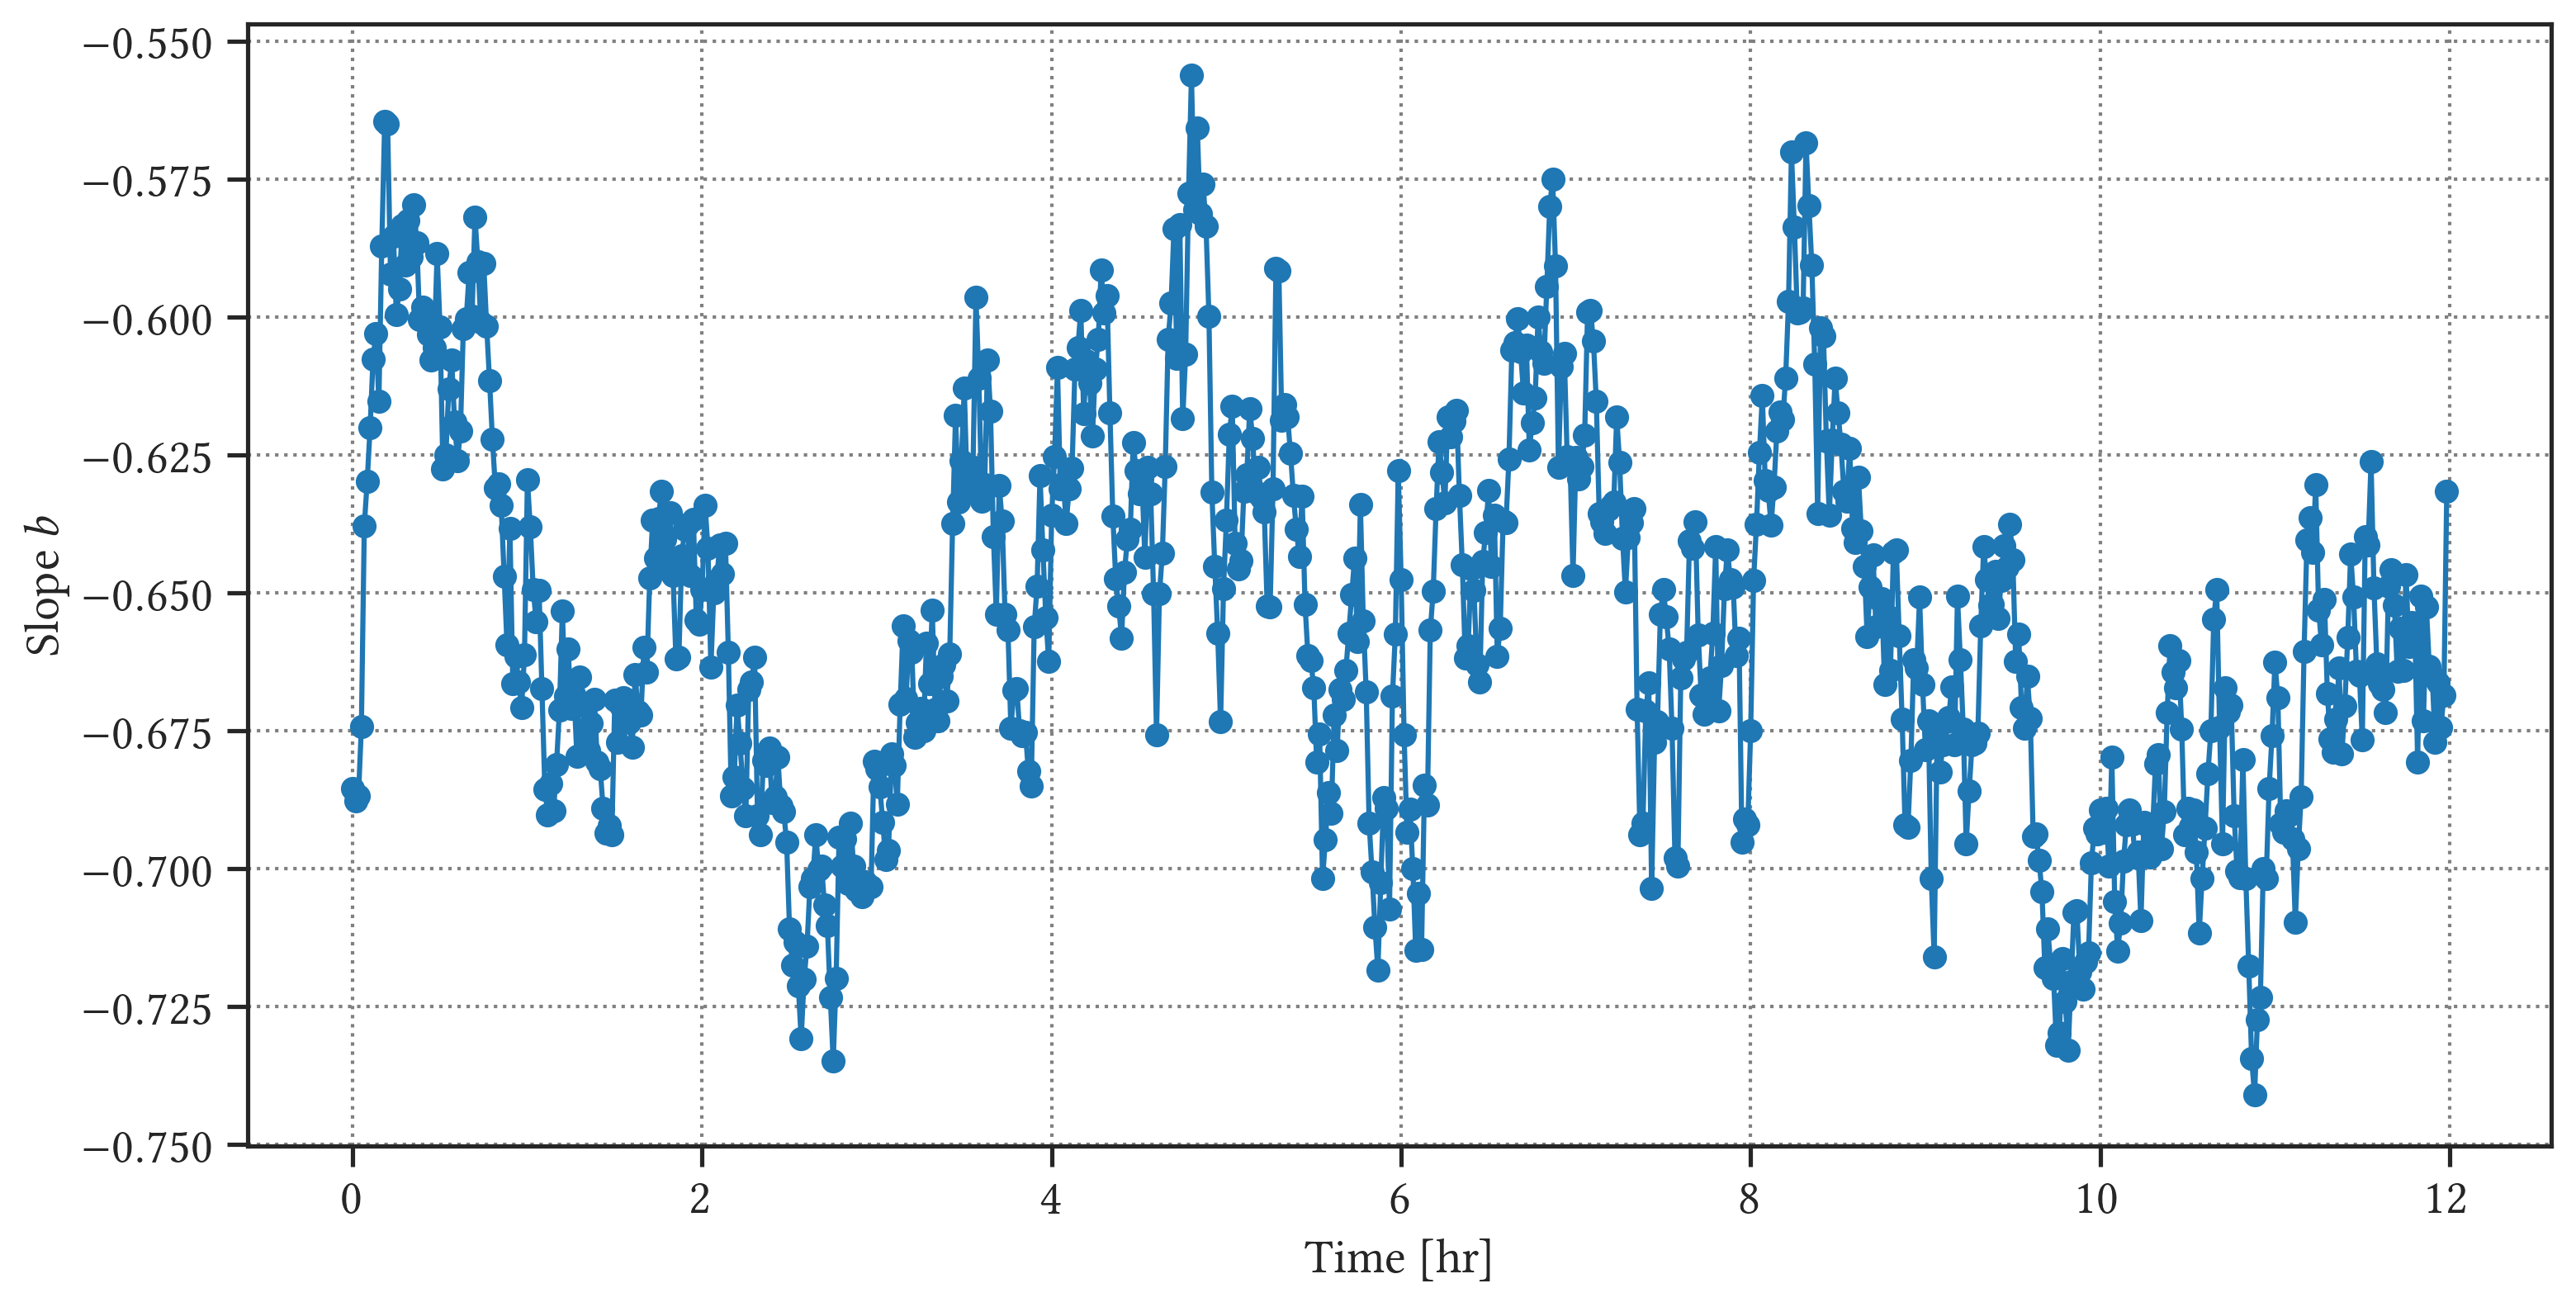

In [7]:
# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6), dpi=300)
ax.plot(x_tr / 60, y_tr, 'o-')

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

In [8]:
if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

 At this point, it is difficult to say if there is any oscillation in the timeseries (I'd be guessing). There is too much noise, and the general trend makes it difficult to see if there is an oscillatory motion. 

 I have a feeling if we tested the timeseries of cloud cover found in other studies, we might be able to find periodic motions in the cloud size distribution. That would be an interesting study, and I have already done so for BOMEX, GCSSARM, as well as CGILS. Both mass flux and cloud cover demonstrate periodic changes that can be identified using GP regression (more on this later).

## GP Smoothing

 Let's define our GP model. The prior distribution is not given here, and if I need to, I'd just set it to a uniform distribution (e.g. a uniform probability between 1 and 180 minutes). There is a bit of trial and error involved here, since a good hyperparameter depends on the data and how much smoothing you want to apply.

 Here we use RBF + periodic kernel. We can stick to the RBF kernel, which works well for uniform timeseries, but a periodic kernel keeps the estimate somewhat manageable. Depending on the sampling location, sometimes we are stuck in the middle of the fast transition, and GP interprets it as a quick rise (or fall) in the slope of the cloud size distribution. Because we know this generally does not happen so quickly, I added the periodic kernel.

In [9]:
class SmoothGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(SmoothGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.cov_module = gpytorch.kernels.AdditiveKernel(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)
        
        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov)

In [10]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.GreaterThan(1.e-2),
    noise_prior = gpytorch.priors.NormalPrior(1.e-2, 1)
)
model = SmoothGPModel(x_tr, y_tr, likelihood)

# Initialize kernels
model.cov_module.kernels[0].base_kernel.initialize(
    lengthscale = torch.tensor(30.)
)

model.cov_module.kernels[1].base_kernel.initialize(
    lengthscale = torch.tensor(30.),
    period_length = torch.tensor(90.),
)

model.double()

SmoothGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): GreaterThan(1.000E-02)
    )
  )
  (mean_module): ConstantMean()
  (cov_module): AdditiveKernel(
    (kernels): ModuleList(
      (0): ScaleKernel(
        (base_kernel): RBFKernel(
          (raw_lengthscale_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
      (1): ScaleKernel(
        (base_kernel): PeriodicKernel(
          (raw_lengthscale_constraint): Positive()
          (raw_period_length_constraint): Positive()
        )
        (raw_outputscale_constraint): Positive()
      )
    )
  )
)

In [11]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)
    
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([{'params': model.parameters()},], lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 200
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/200 [00:00<?, ?it/s]

/home/loh/.local/conda/envs/stats/lib/python3.9/site-packages/gpytorch/lazy/triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1647804203612/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


In [12]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -8.135103385992137
mean_module.constant                       	 -0.6549045155542174
cov_module.kernels.0.raw_outputscale       	 -7.650720556693357
cov_module.kernels.0.base_kernel.raw_lengthscale 	 36.99864400257333
cov_module.kernels.1.raw_outputscale       	 -6.496097263897735
cov_module.kernels.1.base_kernel.raw_lengthscale 	 22.996075852599365
cov_module.kernels.1.base_kernel.raw_period_length 	 95.44535133823892


 The learning rate looks good. It may be a bit too fast (only 200 epochs), but a slower learning rate does not improve the result.

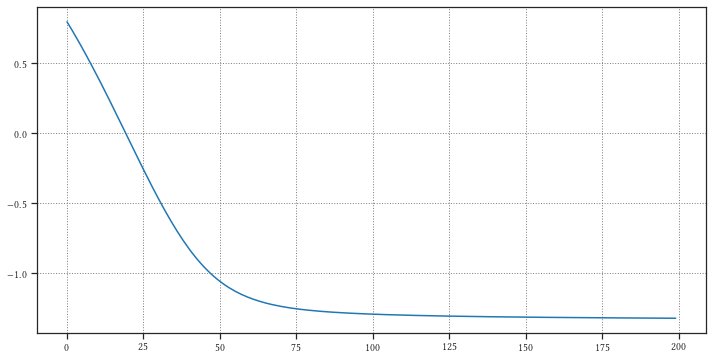

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [14]:
dt = 90

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

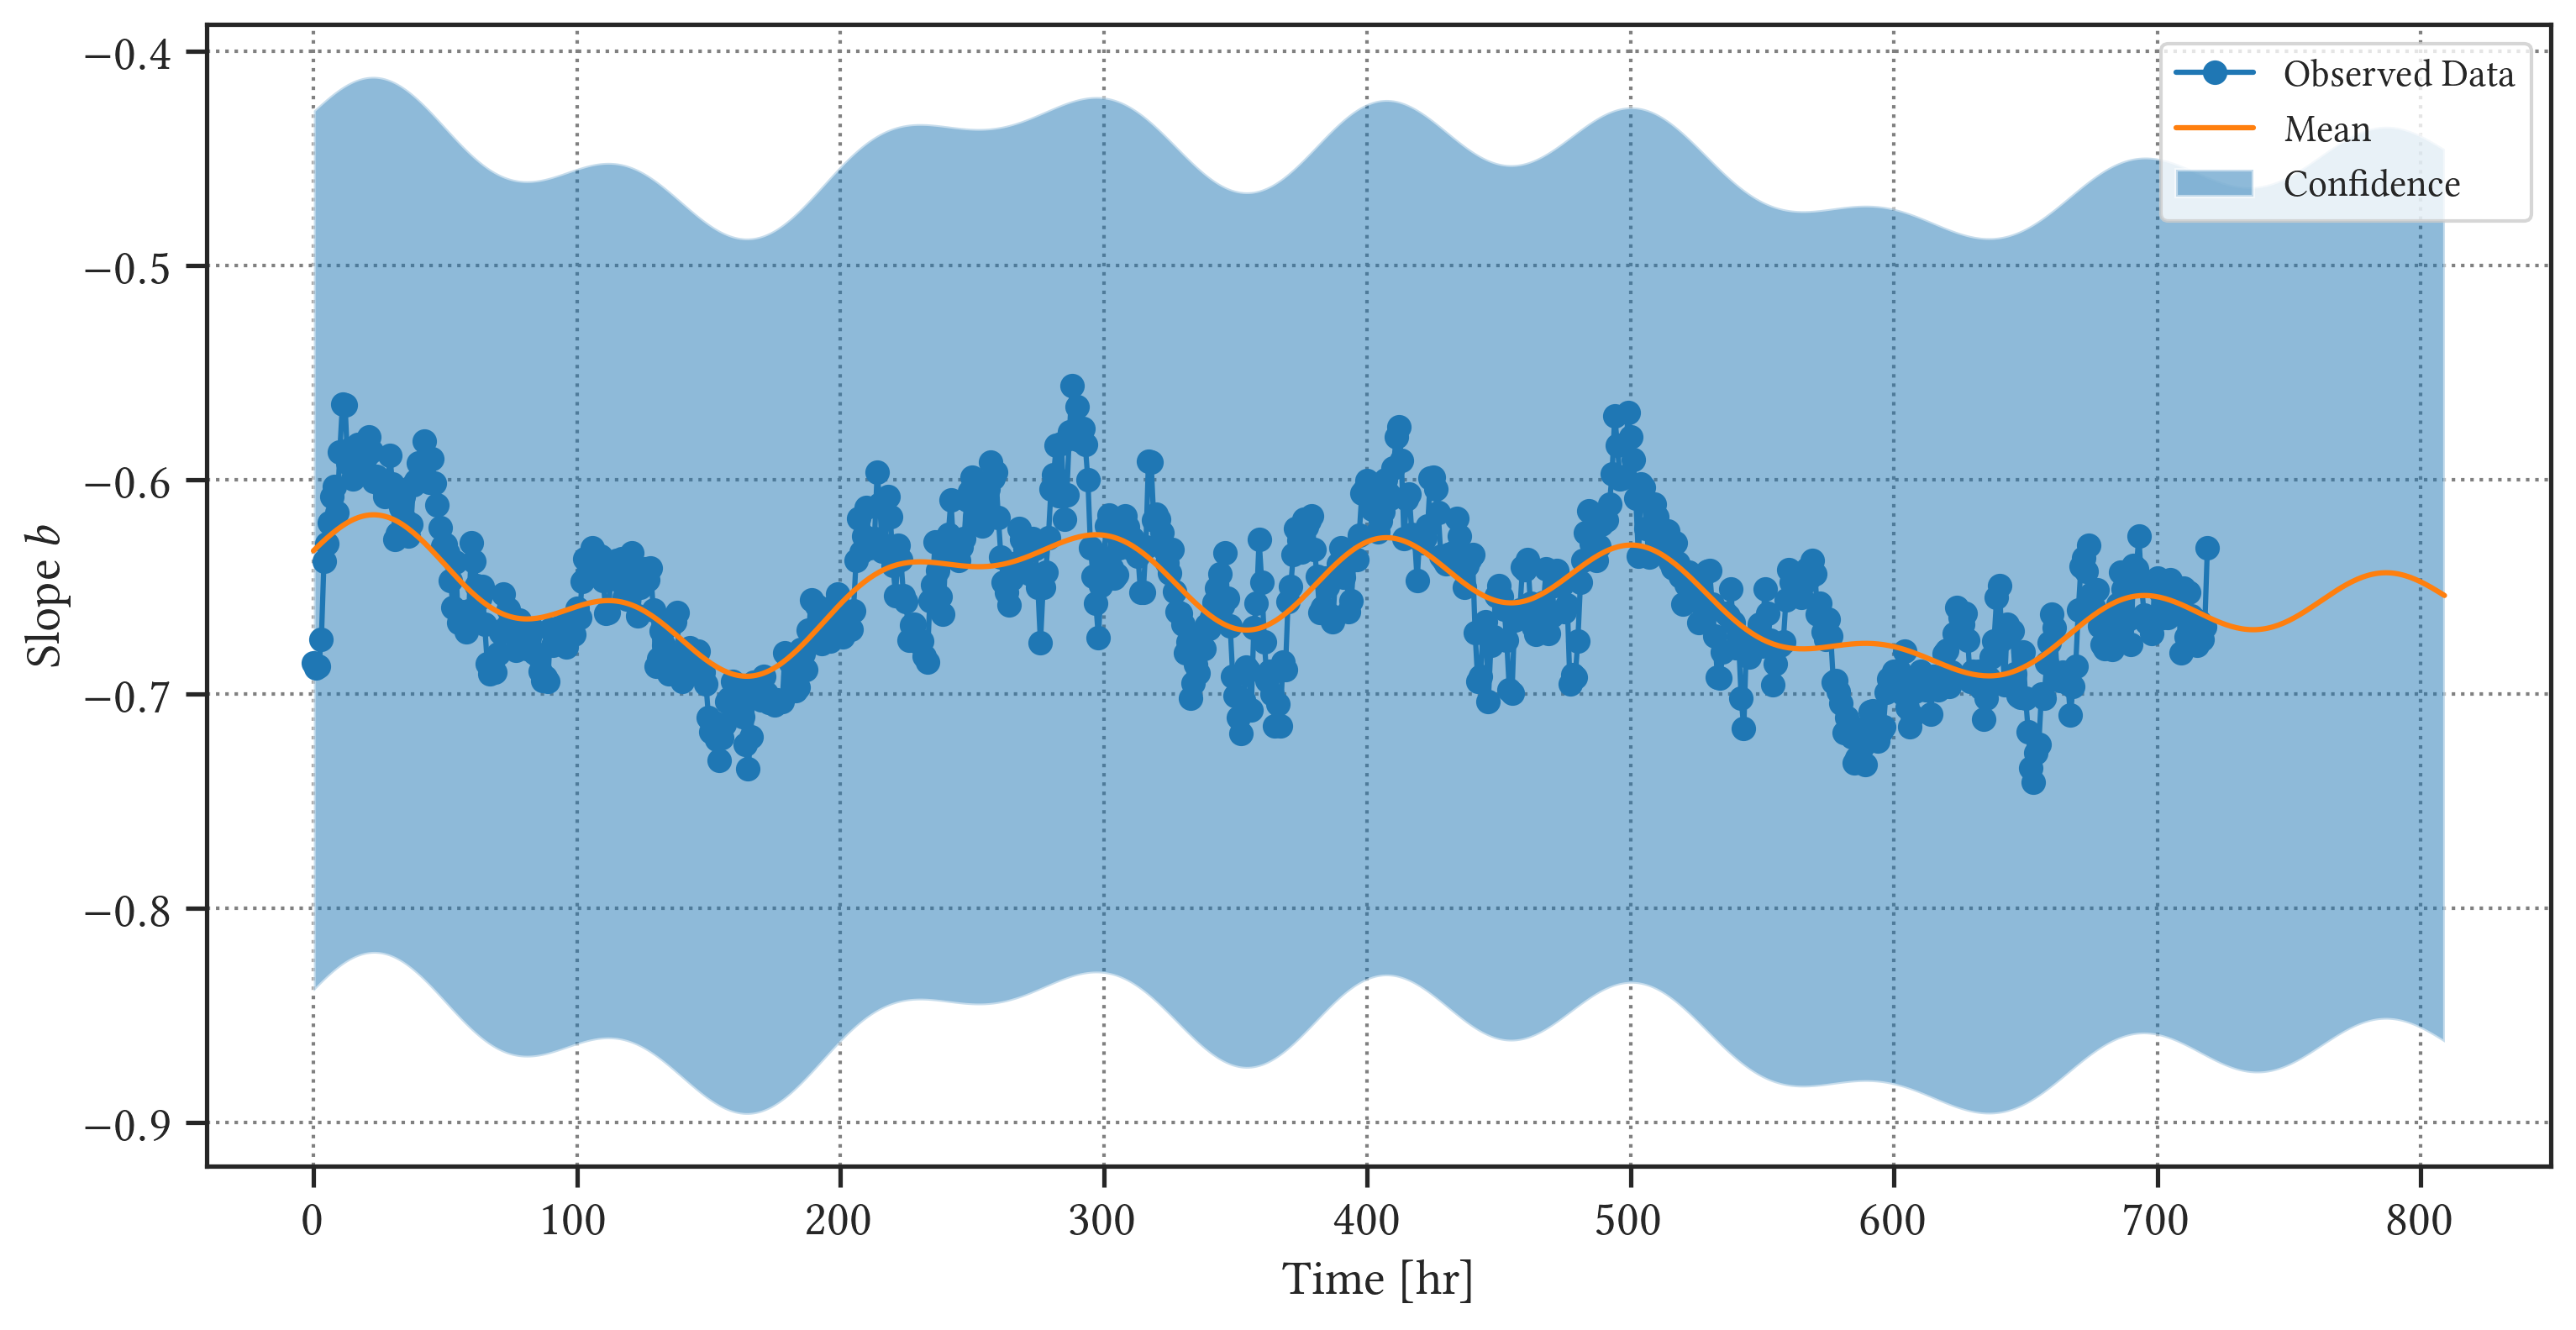

In [15]:
if device.type == 'cuda':
    model = model.cpu()
    likelihood = likelihood.cpu()

    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_tr, y_tr, 'o-')
ax.plot(x_test, y_mean)
ax.fill_between(x_test, lower, upper, alpha=0.5)

ax.legend(['Observed Data', 'Mean', 'Confidence'])

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

 It may look like I am being too aggressive with the smoothing, but that's because of the long-term trend in the timeseries and the uncertainty is higher because of it. Of course, I want to remain faithful to the (albeit noisy) data. Reducing the length scales for the two kernels definitely help achieve a much better fit, but it is easy to overfit the dataset while not improving the quality of the regression (and especially the periodicity estimation). Overfitting is definitely more harmful than noise.

 The hyperparameters used aren't meant to be accurate, as they are driven by noisy data. The goal here is to smooth out the noise and local variations to obtain a more general trend. 
 
 At times, depending on the data, GP regression will pick up a long-term trend (e.g. over 2-3 hours). In that case, we will have to repeat the regression until no periodic motions can be observed. For the slope of cloud size distribution, fortunately for me, it is not needed.

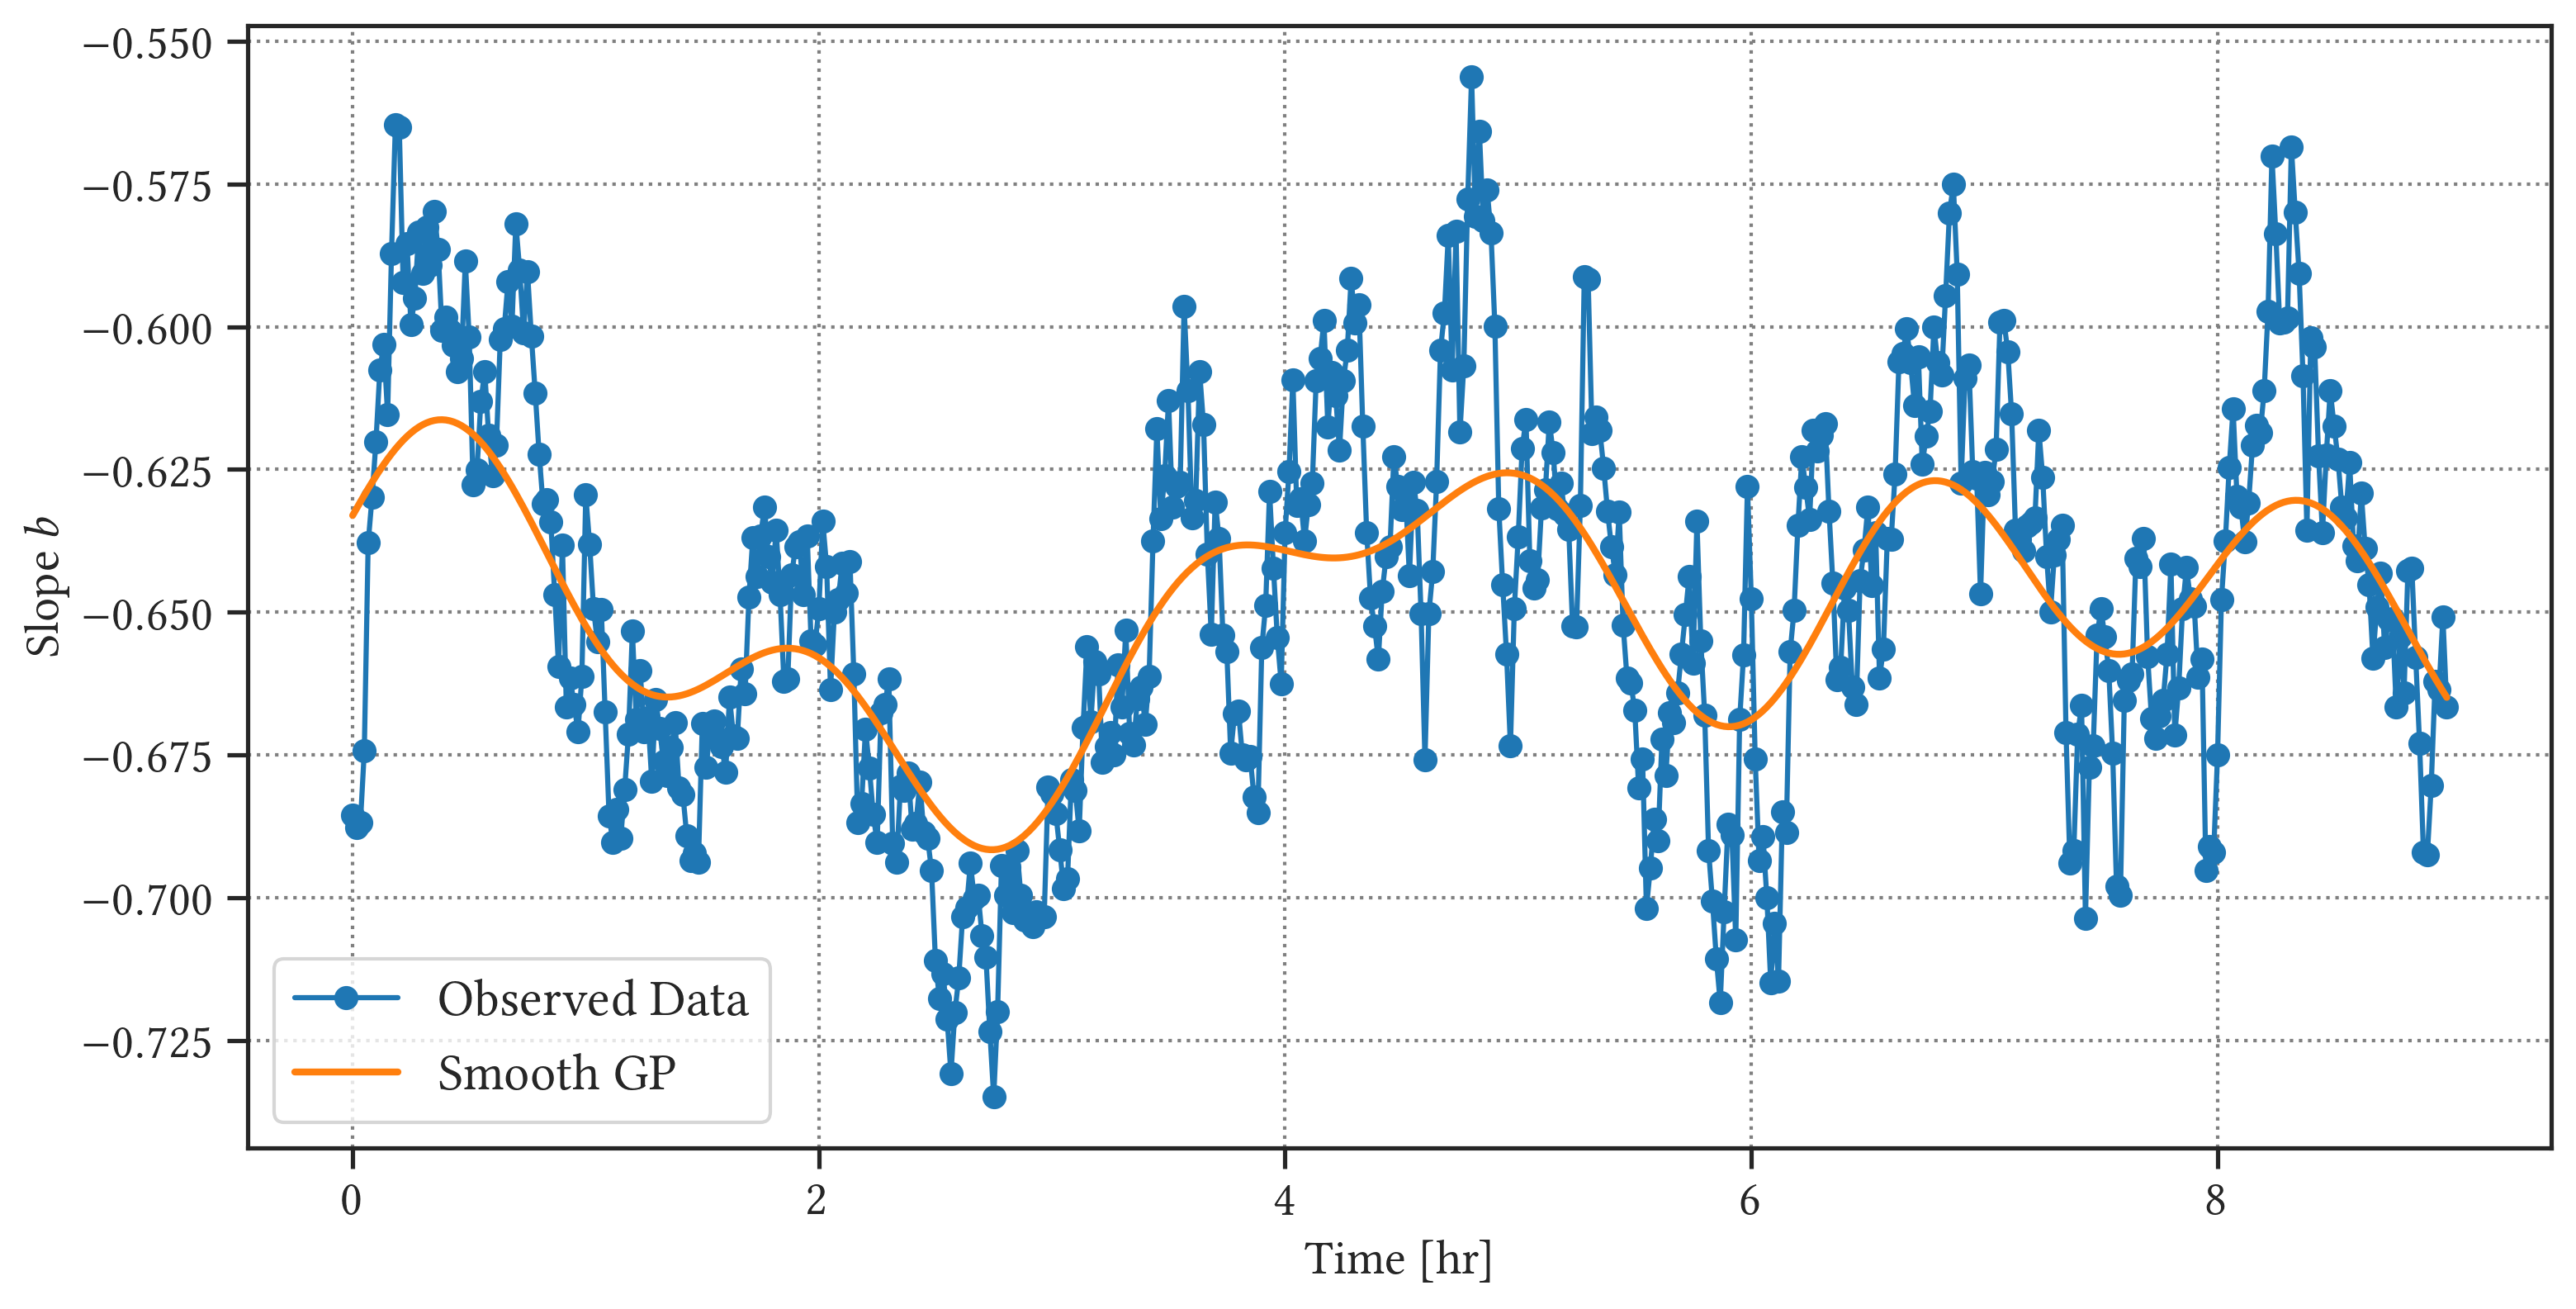

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_full[:540] / 60, y_full[:540], 'o-')
ax.plot(x_test[:540] / 60, y_mean[:540], "C1", lw=2)

ax.legend(['Observed Data', 'Smooth GP'], fontsize=15)

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=14)

 What do we do with the smooth regression? I used an RBF kernel because it is infinitely differentiable, which is useful. There are a lot of different ways to make a timeseries suitable for regression, but here I find a simply differentiation very powerful in isolating the periodic motion in the timeseries. This also makes the average roughly zero, across, which means that this periodic motion is independent of the general, long-term downward trend seen above. This has an added benefit of making the GP regression much easier, since the only parameter we need to worry about at this point is the periodicity.

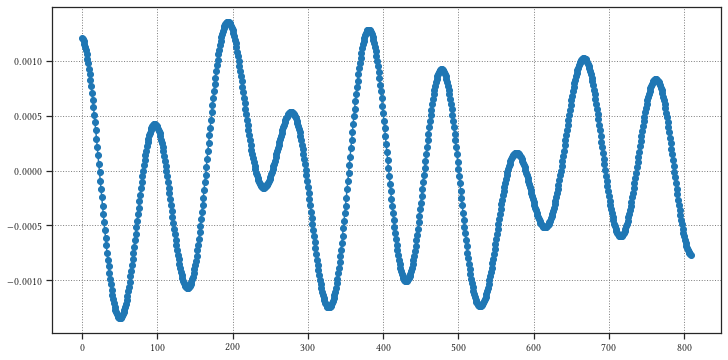

In [17]:
y_grad = np.gradient(y_mean)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x_test, y_grad, 'o-')

## GP Regression with Periodic Kernel

In [18]:
x_tr = x_test.clone().detach().double()
y_tr = torch.tensor(y_grad, dtype=torch.double)

if device.type == 'cuda':
    x_tr = x_tr.to(device)
    y_tr = y_tr.to(device)

 Let's re-define the model. Now, we will only use a single periodic kernel with relatively smaller noise. The lengthscale parameter does not seem to matter too much, and I can use a 90-minute periodicity as a prior based on the results from the previous GP regression.

In [19]:
class PeriodicGPModel(gpytorch.models.ExactGP):
    def __init__(self, x_tr, y_tr, likelihood):
        super(PeriodicGPModel, self).__init__(x_tr, y_tr, likelihood)
        
        self.mean_module = gpytorch.means.ZeroMean()
        
        self.cov_module = gpytorch.kernels.ScaleKernel(
            base_kernel = gpytorch.kernels.PeriodicKernel()
        )

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_cov = self.cov_module(x)

        return gpytorch.distributions.MultivariateNormal(x_mean, x_cov, validate_args=True)

In [20]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint = gpytorch.constraints.Positive(),
    noise_prior = gpytorch.priors.NormalPrior(1e-4, 1e-2),
)
model = PeriodicGPModel(x_tr, y_tr, likelihood)

model.cov_module.base_kernel.initialize(
    period_length = torch.tensor(95.),
)

model.double()

PeriodicGPModel(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): NormalPrior()
      (raw_noise_constraint): Positive()
    )
  )
  (mean_module): ZeroMean()
  (cov_module): ScaleKernel(
    (base_kernel): PeriodicKernel(
      (raw_lengthscale_constraint): Positive()
      (raw_period_length_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

In [21]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:48} \t {param.item()}")
    
print(f"\n {model.cov_module.base_kernel}")

likelihood.noise_covar.raw_noise                 	 0.0
cov_module.raw_outputscale                       	 0.0
cov_module.base_kernel.raw_lengthscale           	 0.0
cov_module.base_kernel.raw_period_length         	 95.0

 PeriodicKernel(
  (raw_lengthscale_constraint): Positive()
  (raw_period_length_constraint): Positive()
)


In [22]:
# Find optimal model hyperparameters
if device.type == 'cuda':
    model = model.to(device)
    likelihood = likelihood.to(device)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

max_iter = 400
losses = []

p_bar = tqdm(range(max_iter))
for i in p_bar:
    optimizer.zero_grad()
    output = model(x_tr)
    loss = -mll(output, y_tr)
    losses += [loss.item()]
    loss.backward()

    period = model.cov_module.base_kernel.raw_period_length.item()

    p_status = f"{i + 1:3d}/{max_iter:3d} Loss: {loss.item():.3f} Period: {period:.3f}"
    p_bar.set_description(p_status)
    
    optimizer.step()

  0%|          | 0/400 [00:00<?, ?it/s]

In [23]:
# Model parameters
for param_name, param in model.named_parameters():
    print(f"{param_name:42} \t {param.item()}")

likelihood.noise_covar.raw_noise           	 -15.7453592562146
cov_module.raw_outputscale                 	 -13.603589379927834
cov_module.base_kernel.raw_lengthscale     	 7.66374431183383
cov_module.base_kernel.raw_period_length   	 95.38142374803759


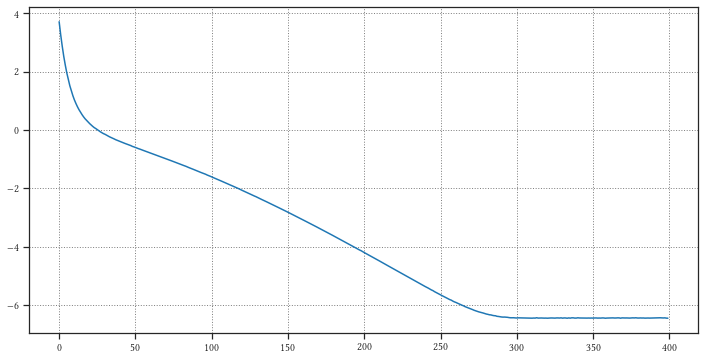

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(np.arange(len(losses)), losses)

In [25]:
dt = 180

# Make predictions by feeding model through likelihood
x_test = torch.arange(x_tr.size(dim=0) + dt, dtype=torch.double)
if device.type == 'cuda':
    x_test = x_test.to(device)

model.eval()
likelihood.eval()

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed = likelihood(model(x_test))
    y_mean = observed.mean
    lower, upper = observed.confidence_region()

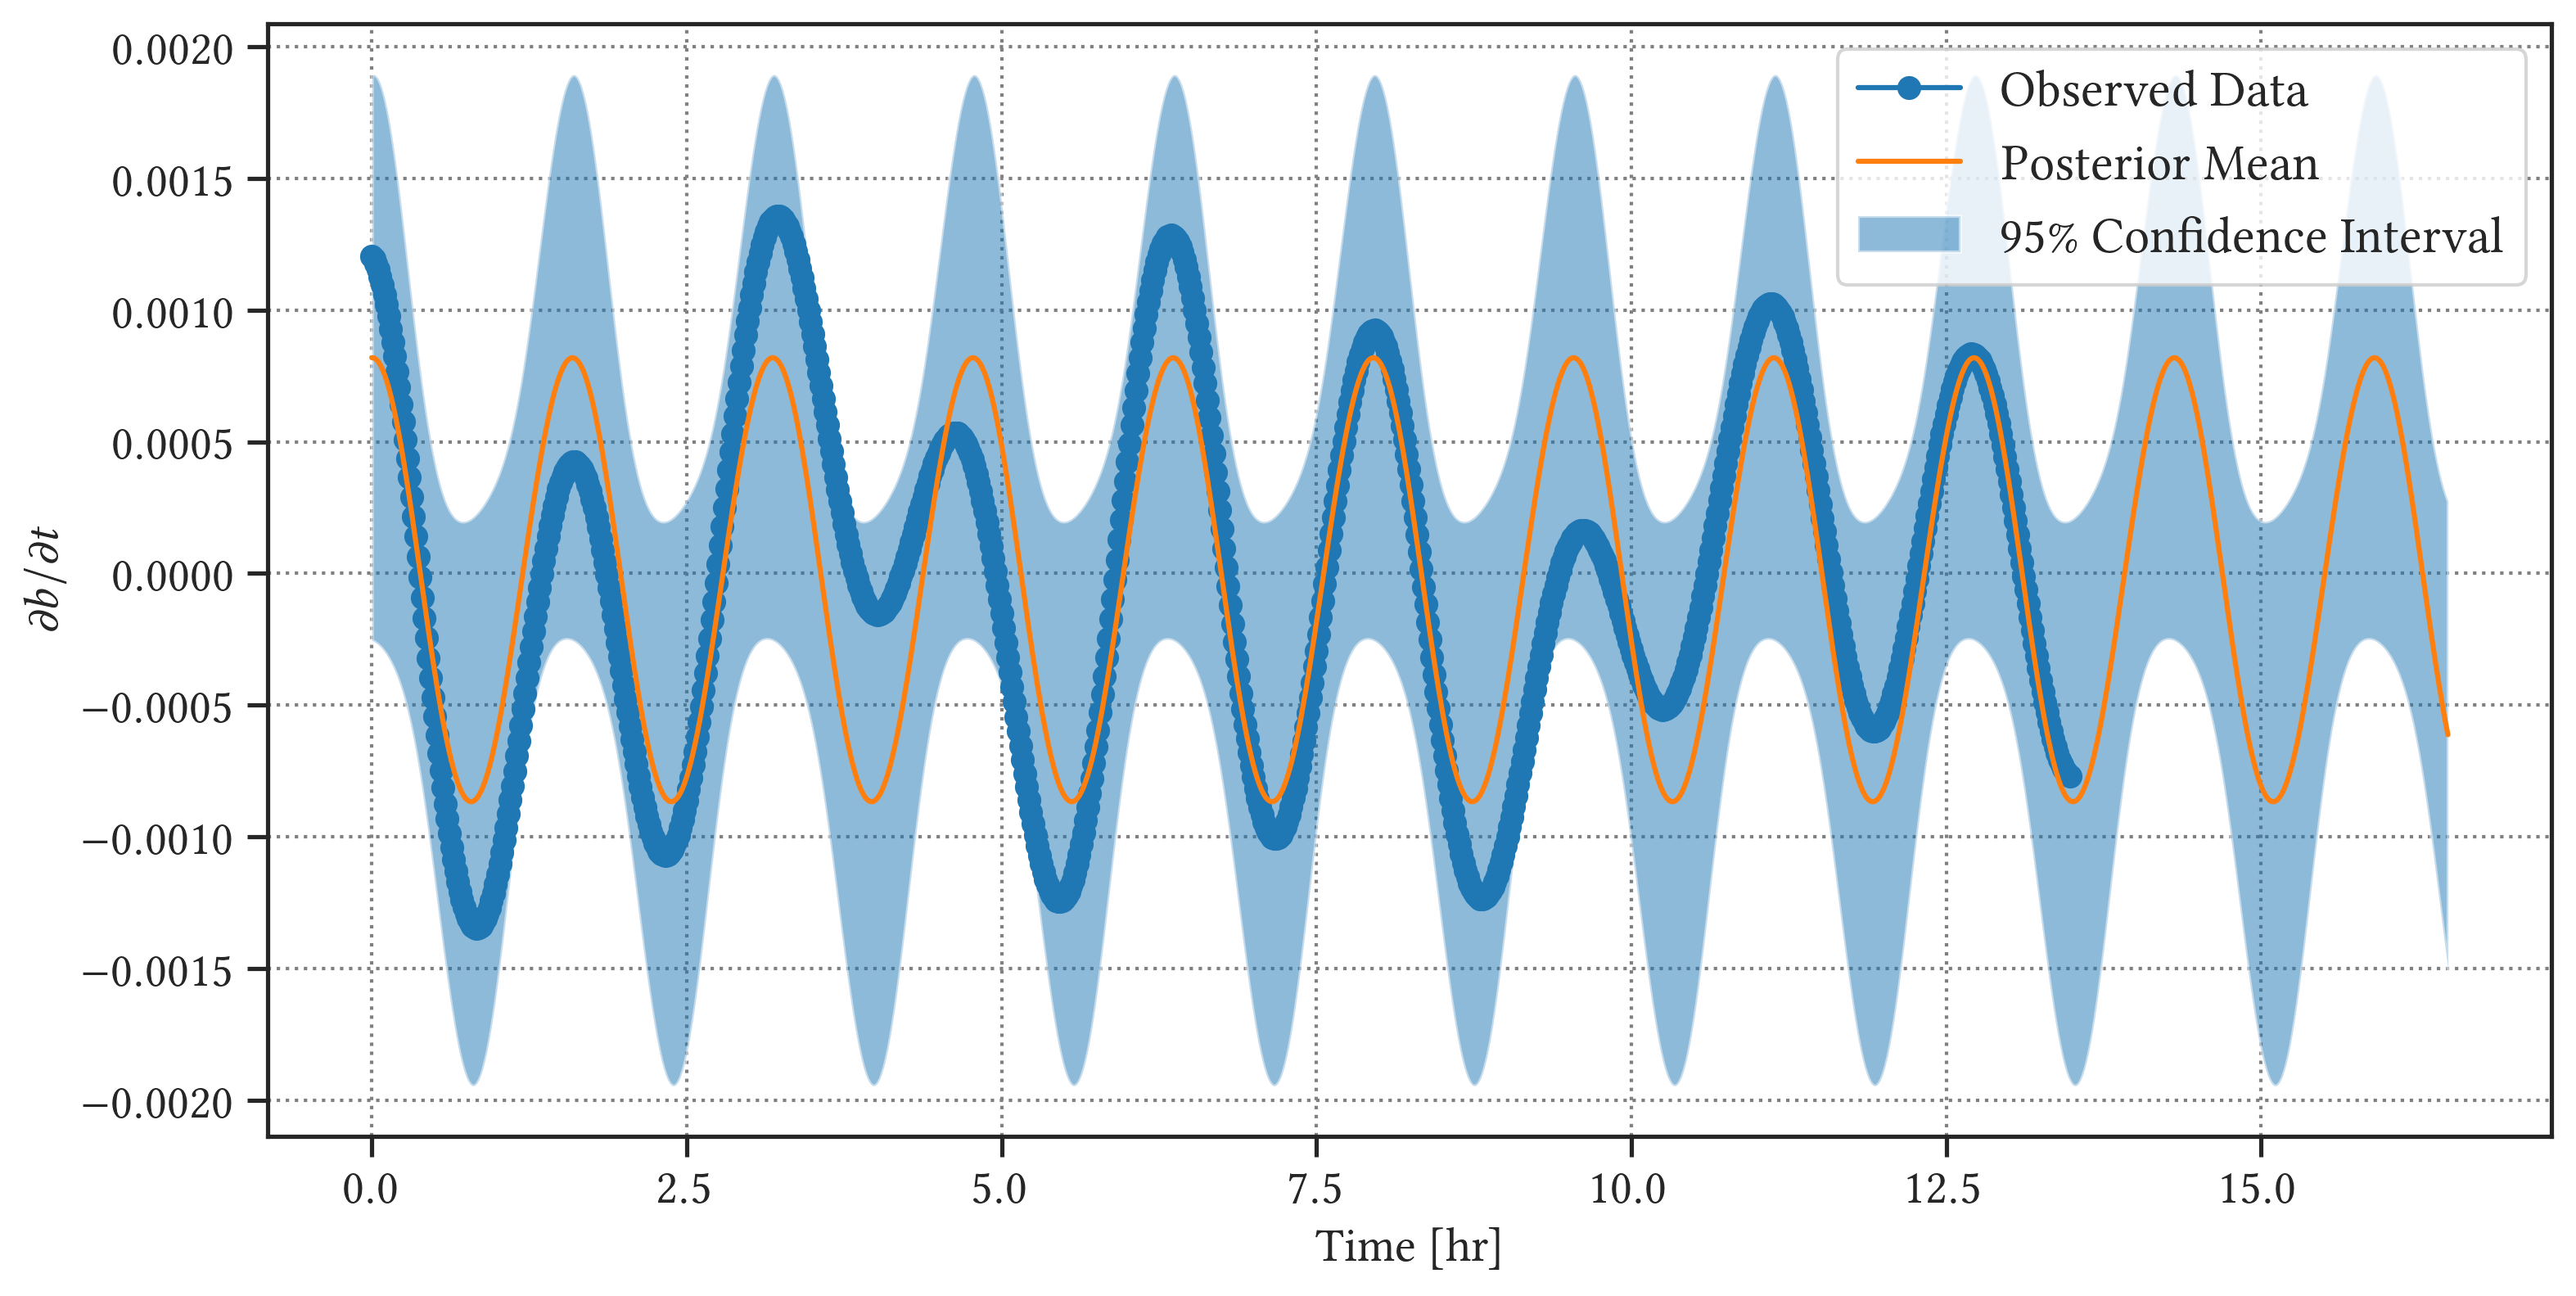

In [26]:
if device.type == "cuda":
    model = model.cpu()
    likelihood = likelihood.cpu()

    x_tr = x_tr.cpu()
    y_tr = y_tr.cpu()

    x_test = x_test.cpu()
    y_mean = y_mean.cpu()
    lower = lower.cpu()
    upper = upper.cpu()

# Initialize plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_tr / 60, y_tr, "o-")
ax.plot(x_test / 60, y_mean)
ax.fill_between(x_test / 60, lower, upper, alpha=0.5)

ax.legend([
    "Observed Data",
    "Posterior Mean",
    "95\% Confidence Interval"], fontsize=15)

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("$\partial b / \partial t$", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=14)



 The mean posterier distribution seem to match well with the smooth timeseries. The mean posterier distribution has a single period (92 minutes), which means that the actual data shifts slightly between oscillations. Previously using scikit-learn's GP model, I ended up using a multi-periodic kernel (e.g. 45 minutes and 75 minute periods). How can we be sure that it is indeed local variation, not an underlying oscillation?

 One thing we can do is to use the fact that we know the timeseries oscillates mainly every 92 minutes. So, I can simply segment the smooth timeseries (not the posterier distribution, of course) at every 92 minutes. If there is an underlying oscillation, we will see that in the following figure.

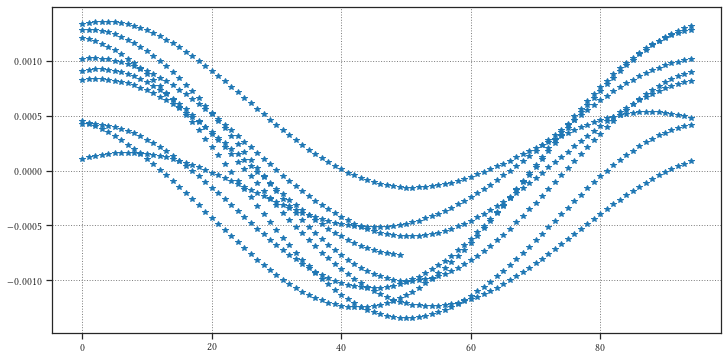

In [27]:
# Redefine training domain
x_tr_rep = np.mod(x_tr, 95)

# Plot
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
ax.plot(x_tr_rep, y_tr, '*')

 And now we can be sure that there is no underlying oscillation here.

 But how do we show this works? It needs a bit of work, unfortunately. Since the original timeseries is noisy and non-uniform, we need to get rid of the general trend. I run a simple Lowess (which calculates moving average/regression) to make sure that the timeseries is (semi-)stable. Then the timeseries is scaled using the min-max normalization.

 The same process is done for the GP posterier distribution, except for local regression because we only used a periodic kernel, which has no general trend (just a simple oscillating motion). Comparing the two should give us a good idea about how well the GP regression works for periodicity detection.

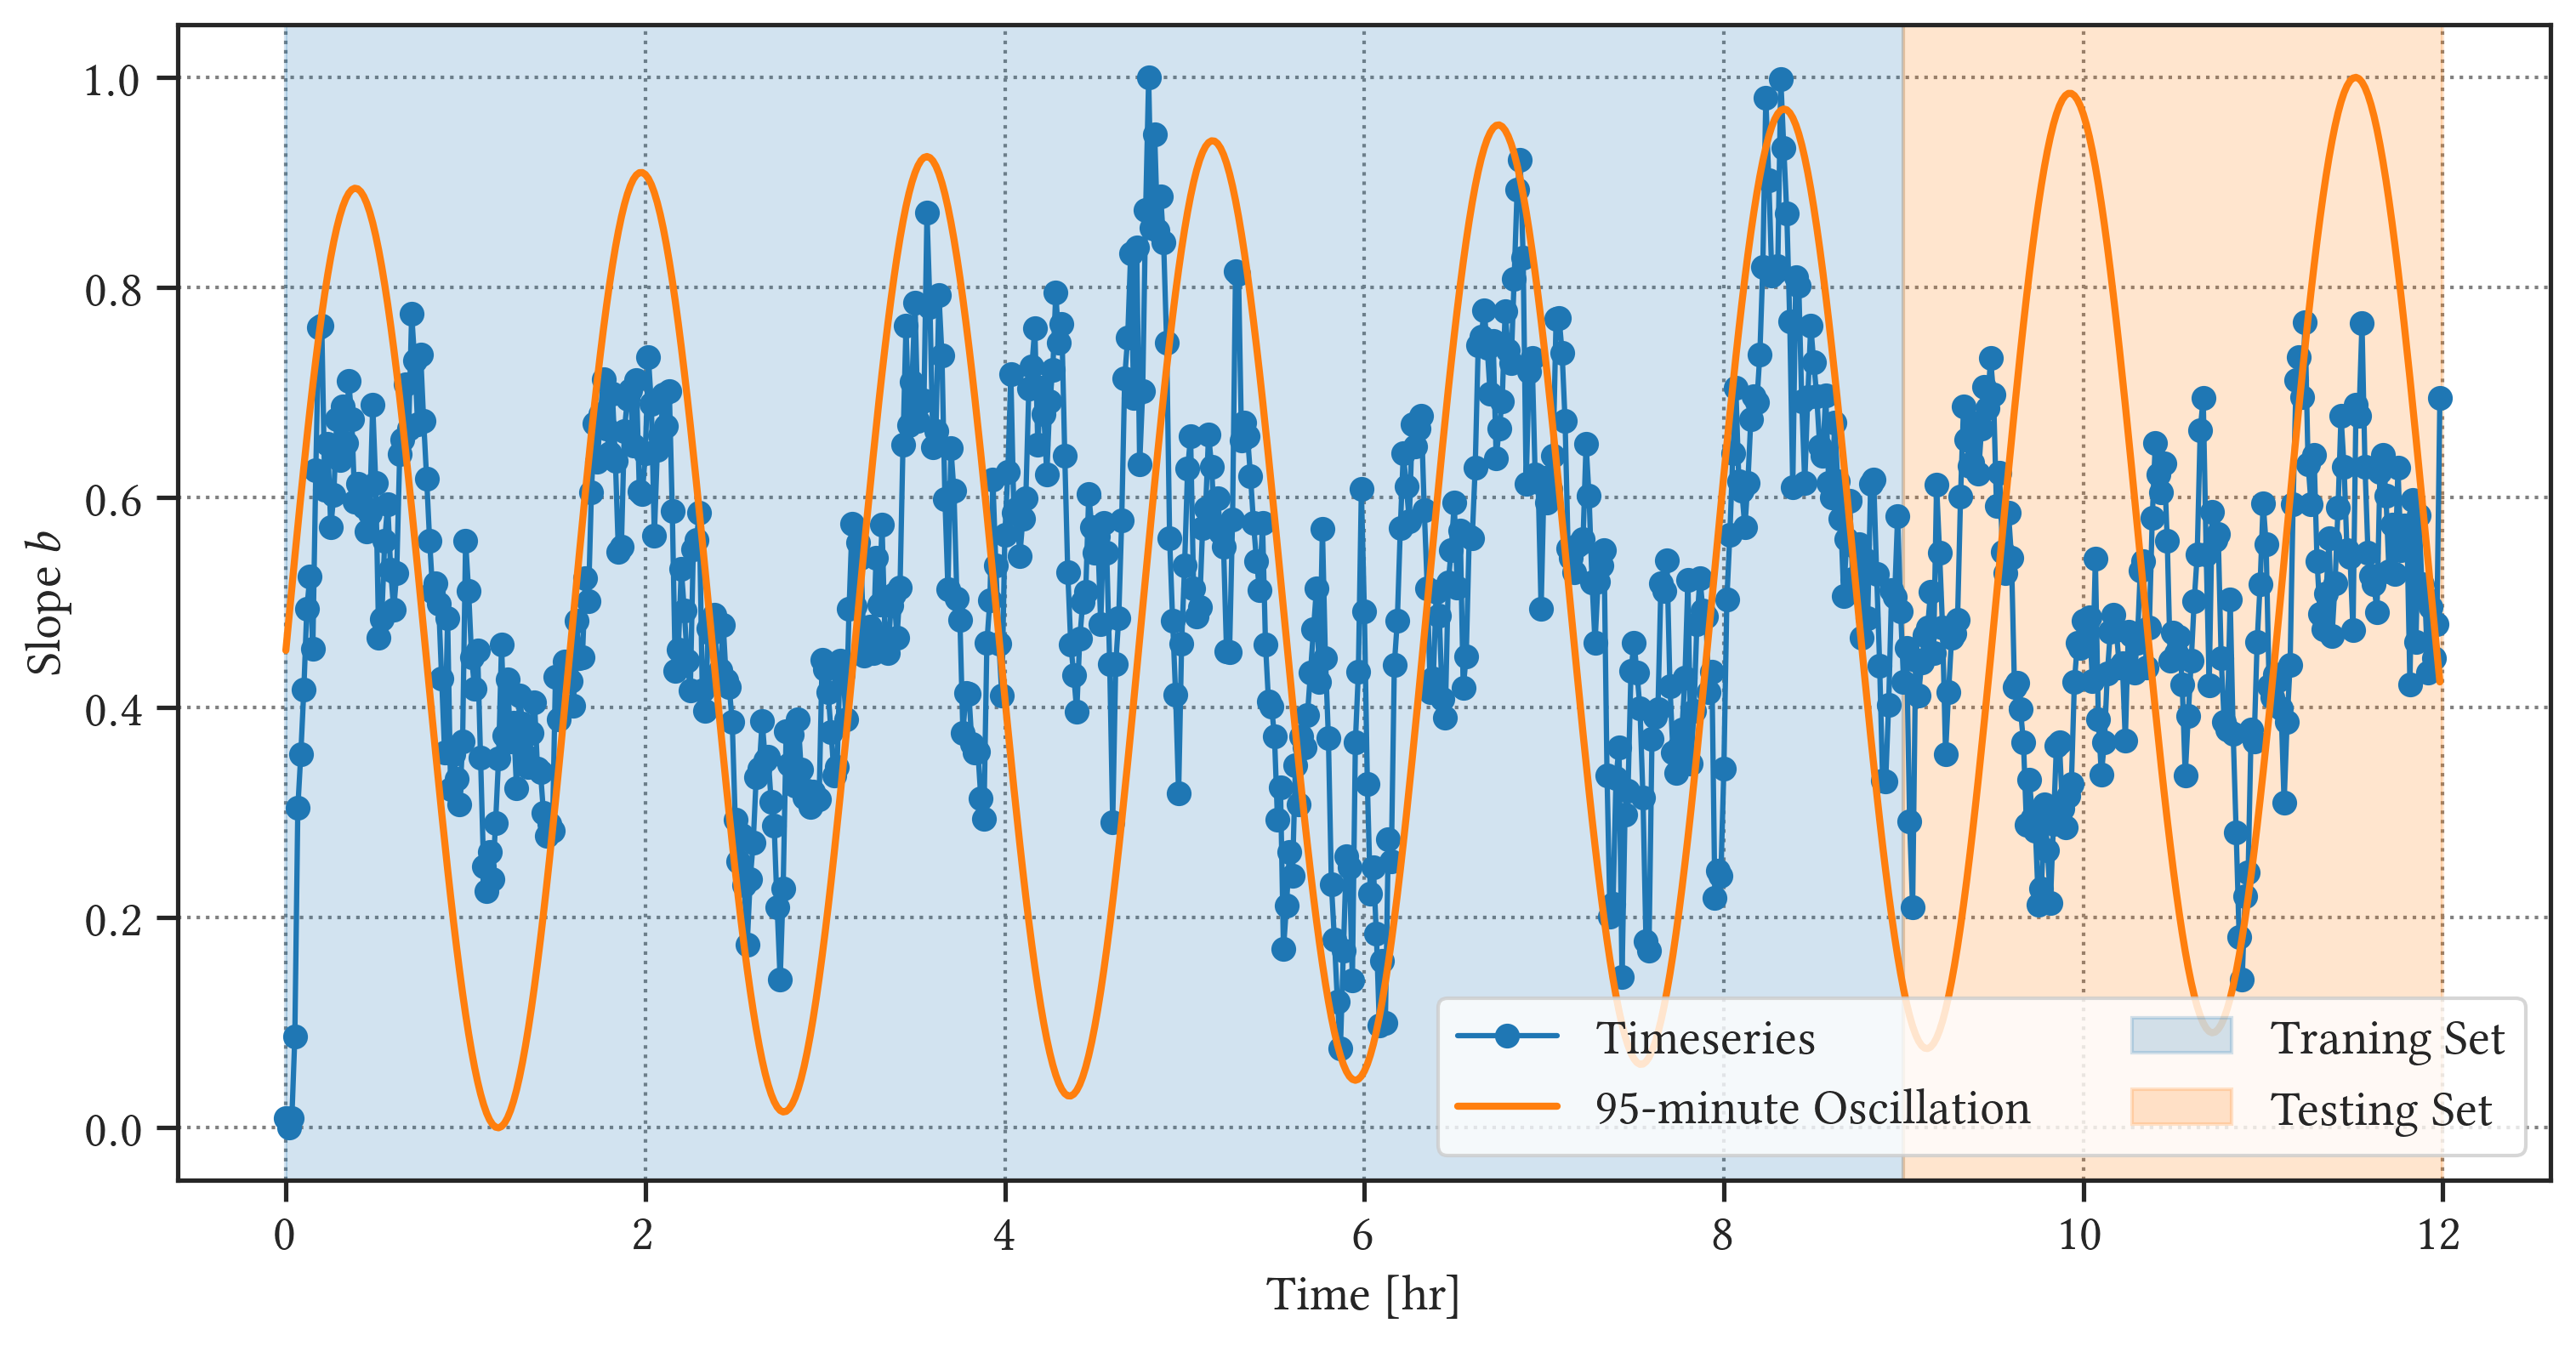

In [28]:
y_pr = y_mean.numpy()[:720]
y_pr = np.cumsum(y_pr - np.mean(y_pr, axis=0))

y_sl = y_full[:720] - sl.lowess(y_full[:720], x_full[:720], return_sorted=False, frac=0.3)

x_c = np.arange(len(y_pr)) / 60

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6), dpi=300)

ax.plot(x_c,
    skl_prep.minmax_scale(y_sl[:, None], axis=0),
    "o-",
    label="Timeseries")
ax.plot(
    x_c,
    skl_prep.minmax_scale(y_pr[:, None], axis=0),
    "-",
    lw=2,
    label="95-minute Oscillation",
)

ax.axvspan(0, 9, alpha=0.2, color="C0", label="Traning Set")
ax.axvspan(9, 12, alpha=0.2, color="C1", label="Testing Set")

ax.legend(loc=0, ncol=2, frameon=True, fontsize=14)

ax.set_xlabel("Time [hr]", fontsize=14)
ax.set_ylabel("Slope $b$", fontsize=14)

ax.tick_params(axis="both", which="major", labelsize=14)

 That looks great.